In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

pd.options.display.max_columns =100

# Import Data

In [5]:
df = pd.read_csv("data/breast_cancer.csv")
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [7]:
df.target.value_counts(normalize=True)

1.0    0.627417
0.0    0.372583
Name: target, dtype: float64

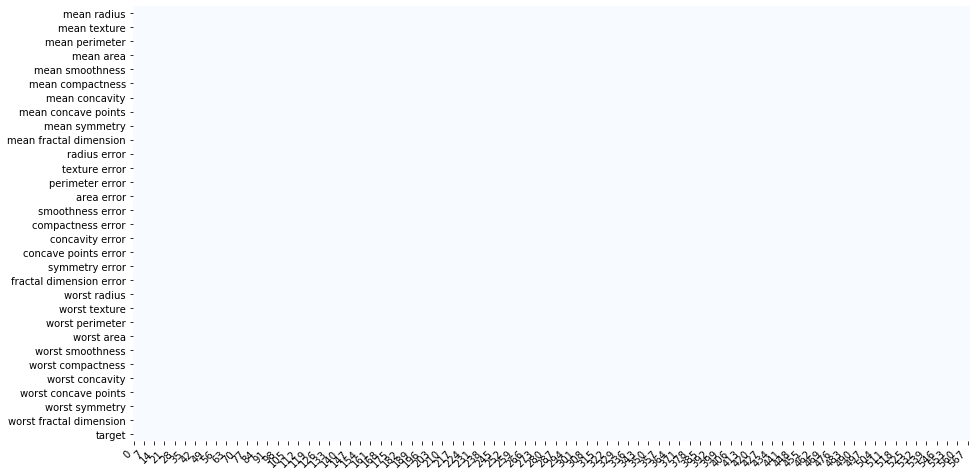

In [8]:
plot_missing_value(df)

# Dataset spliting

In [9]:
X = df.drop(columns="target")
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

# Visualize cara kerja PCA

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
pca = PCA(n_components=2, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [14]:
X_train_pca.shape

(455, 2)

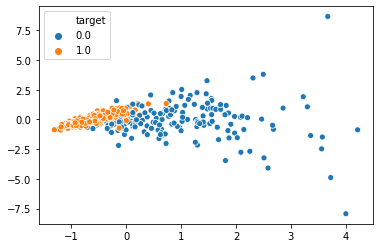

In [15]:
sns.scatterplot(X_train_pca[:,0],X_train_pca[:,1], hue=y_train)

# Training

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [17]:
X_train.head(1)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
546,10.32,16.35,65.31,324.9,0.09434,0.04994,0.01012,0.005495,0.1885,0.06201,0.2104,0.967,1.356,12.97,0.007086,0.007247,0.01012,0.005495,0.0156,0.002606,11.25,21.77,71.12,384.9,0.1285,0.08842,0.04384,0.02381,0.2681,0.07399


In [19]:
from jcopml.tuning.space import Real, Integer

In [21]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA()),
    ('algo', SVC(max_iter=500))
])

params ={
        'algo__gamma': Real(low=-3, high=3, prior='log-uniform'),
        'algo__C': Real(low=-3, high=3, prior='log-uniform'),
        'pca__n_components':Integer(1,30),
        'pca__whiten':[True,False]
         }

model = RandomizedSearchCV(pipeline, params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.6s


{'algo__C': 3.907967156822884, 'algo__gamma': 0.008632008168602547, 'pca__n_components': 19, 'pca__whiten': True}
0.9736263736263736 0.9582607180202162 0.9736842105263158


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.4s finished


In [18]:
rsp.svm_params

{'algo__gamma': Real(low=-3, high=3, prior='log-uniform'),
 'algo__C': Real(low=-3, high=3, prior='log-uniform')}

In [23]:
pipeline.get_params()

{'memory': None,
 'steps': [('prep',
   ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                     transformer_weights=None,
                     transformers=[('numeric',
                                    Pipeline(memory=None,
                                             steps=[('imputer',
                                                     SimpleImputer(add_indicator=False,
                                                                   copy=True,
                                                                   fill_value=None,
                                                                   missing_values=nan,
                                                                   strategy='median',
                                                                   verbose=0))],
                                             verbose=False),
                                    Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
   

# Bagaimana menentukan n_components -> Culmulative Explained Variance

In [24]:
pca = PCA().fit(X_train)

Text(0, 0.5, 'Culmulative Explained Variance')

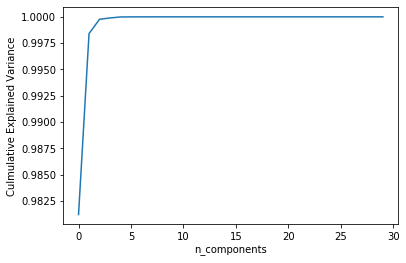

In [25]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel("n_components")
plt.ylabel("Culmulative Explained Variance")

In [28]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA(n_components=5, whiten=True)),
    ('algo', SVC(max_iter=500))
])

model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished


{'algo__C': 98.77700294007921, 'algo__gamma': 0.01879466824163846}
0.9692307692307692 0.9626612059951202 0.9649122807017544
